# <center> Feature engineering: TSFresh performance

In [87]:
%store -r __ipy
%store -r __da
%store -r __ml

In [80]:
__ipy

Helper ipython script loaded


In [81]:
__da

Basic Data Analysis tools was loaded


In [88]:
__ml

In [5]:
train_df = pd.read_pickle(root + 'train_features.pkl')

In [6]:
n_samples = 100000
segments = train_df.shape[0] / n_samples

In [7]:
train_df = pd.read_pickle(root + "train_features.pkl")
train_t = train_df[:n_samples]

def tsfresh_time(sett, column_sort, column_value, res):
    for f, param in tqdm(sett.items()):
        res.loc[f, "feature"] = f
        fc_dict = {f:param}
        t = timeit.timeit(lambda : extract_features(train_t, 
                         column_id=KEY_NAME,
                         column_sort=column_sort,
                         column_value=column_value,
                         n_jobs=12, 
                         default_fc_parameters=fc_dict, 
                         disable_progressbar=True), 
                         number=3)
        
        res.loc[f, "t_abs"] = t
    return res

def show_ts_performance(settings):
    res=pd.DataFrame()
    res=tsfresh_time(settings, 'timestamp', 'meter_reading_log1p', res)
    res["feature"] = res.feature.astype(str)
    res = res.sort_values(by="feature")

    plt.figure(figsize=(6, 10))
    sns.barplot(y="feature", x="t_abs", data=res)
    plt.title("Runtime of 1 apply features for 1 time series of length %d"  % n_samples)
    
    seconds = np.sum(res["t_abs"]) * segments
    print("Estimated running time: ", seconds)
    print("Estimated running time: ", seconds / 60)
    print("Estimated running time: ", seconds / 60 / 60)
    plt.show()

In [20]:
settings = {
'standard_deviation': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,

'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
'first_location_of_minimum': None,
'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,

 'number_peaks': [{'n': 1}, {'n': 5}],
 'ar_coefficient': [{'coeff': 0, 'k': 10}]
}

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}


Estimated running time:  9640.023531082503


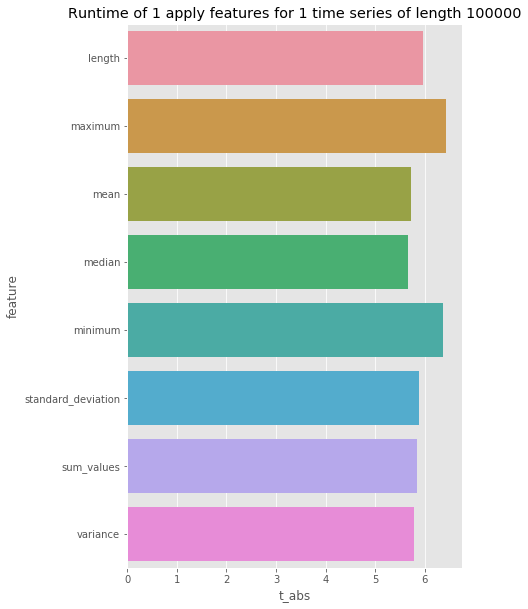

In [21]:
show_ts_performance(MinimalFCParameters())


Estimated running time:  98631.36630548758


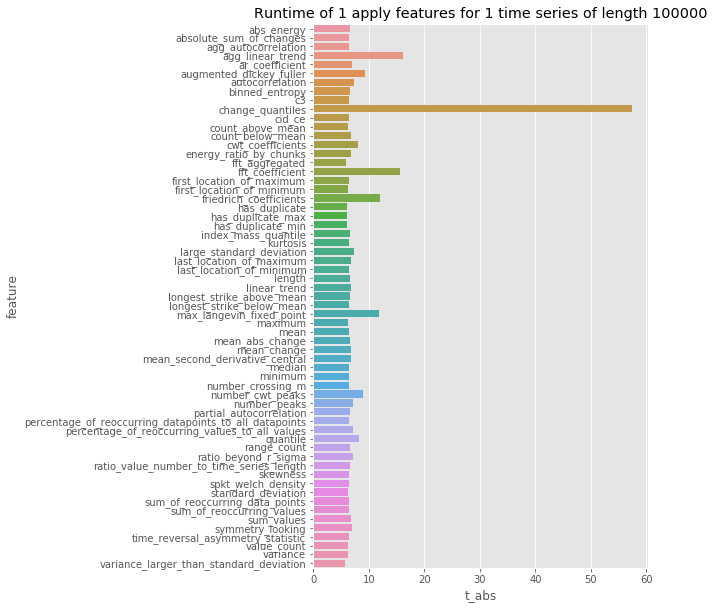

In [22]:
show_ts_performance(EfficientFCParameters())


Estimated running time:  103032.4573277634


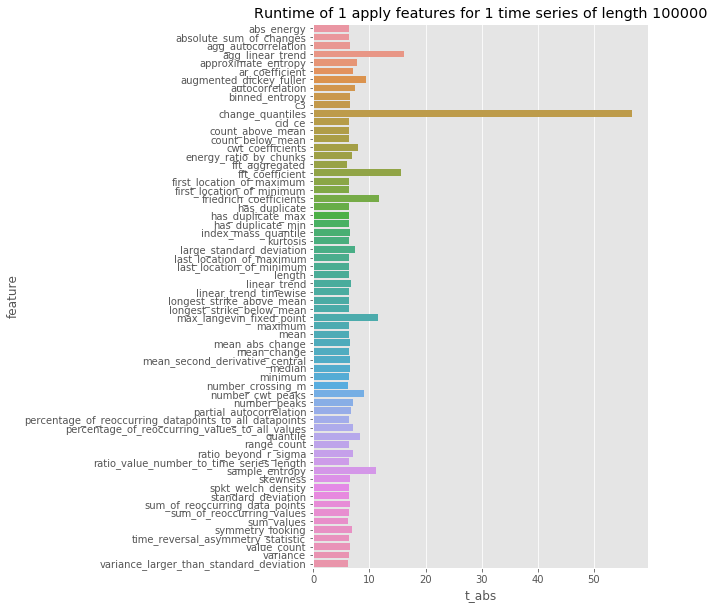

In [23]:
show_ts_performance(ComprehensiveFCParameters())

In [25]:
time_cols = ['month_datetime', 'weekofyear_datetime',
             'dayofyear_datetime', 'hour_datetime', 
             'day_week', 'day_month_datetime',
             'week_month_datetime']

In [ ]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
tscv = KFold(n_splits=5)

start = time.time()

X = train_df[:n_samples]

def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     #impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X


X_filtered = pd.DataFrame()

for i, (train_index, test_index) in tqdm(enumerate(tscv.split(X))):
    X_train = X.loc[test_index] 
    features = ts_features(X_train, 'hour_datetime', 'meter_reading',  MinimalFCParameters())
    X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
#X_filtered=X_filtered.reset_index().drop(['id'], axis=1)

print(X_filtered.shape)

end = time.time()
print("Time",end - start)

In [ ]:
def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X_train, y_col_name, time_cols, k_folds=5):
    tscv = KFold(n_splits=k_folds)
    
    start = time.time()

    X_filtered = pd.DataFrame()

    for time_col in time_cols:
        print(X_train.head())
        features = ts_features(X_train, time_col, y_col_name,  settings)

        for col in features.columns:
            features[col] = features[col].astype(np.float16)

        X_filtered = pd.concat((X_filtered, features.add_suffix(f'_{i}')), axis=1)
    
    X_filtered = X_filtered.replace([np.inf, -np.inf, np.nan], 0)
    impute(X_filtered)
    
    end = time.time()
    print("Time",end - start)
    
    return X_filtered


def generate_and_merge(X_train, X_test=None):
    features = generate_ts_features(X_train, 'meter_reading', ['hour_datetime'], k_folds=6)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if X_test != None:
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test


In [ ]:
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit

start = time.time()

X = train_df[:n_samples]
features = generate_ts_features(X, 'meter_reading_log1p', ['hour_datetime'], k_folds=6)

end = time.time()
print("Time",end - start)

In [34]:
settings = {
 'variance_larger_than_standard_deviation': None,
 'mean_abs_change': None,
 'mean_change': None,
 'median': None,
 'mean': None,
 'standard_deviation': None,
 'variance': None,
 'absolute_sum_of_changes': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [
  {'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': 
  [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'linear_trend': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],

 'augmented_dickey_fuller': [{'attr': 'teststat'},
  {'attr': 'pvalue'},
  {'attr': 'usedlag'}]}


Estimated running time:  28158.71494204907


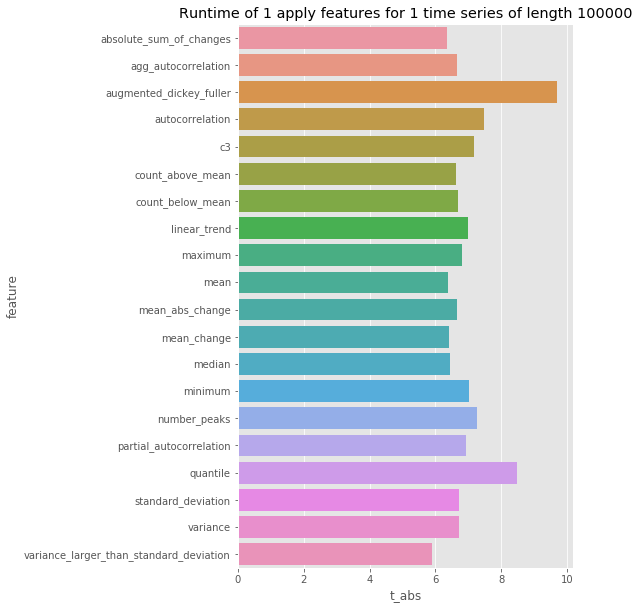

In [35]:
show_ts_performance(settings)

## First attempt

In [7]:
import json

settings = {
 'variance_larger_than_standard_deviation': None,
 'mean_abs_change': None,
 'mean_change': None,
 'median': None,
 'mean': None,
 'standard_deviation': None,
 'variance': None,
 'absolute_sum_of_changes': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'minimum': None,
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [
  {'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': 
  [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'linear_trend': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'augmented_dickey_fuller': [{'attr': 'teststat'},
  {'attr': 'pvalue'},
  {'attr': 'usedlag'}]}

with open(models + 'year_settings.json', 'w') as fp:
    json.dump(settings, fp, indent=4)

## Tuning first attempt

In [6]:
import json

settings = {
 'mean_abs_change': None,
 'mean_change': None,
 'median': None,
 'mean': None,
 'standard_deviation': None,
 'variance': None,
 'absolute_sum_of_changes': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'maximum': None,
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'autocorrelation': [
  {'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 6},
  {'lag': 12}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
    "linear_trend": [
        {
            "attr": "pvalue"
        },
        {
            "attr": "rvalue"
        },
        {
            "attr": "intercept"
        },
        {
            "attr": "slope"
        },
        {
            "attr": "stderr"
        }
    ],
    "agg_linear_trend": [
        {
            "attr": "rvalue",
            "chunk_len": 5,
            "f_agg": "mean"
        },
        {
            "attr": "rvalue",
            "chunk_len": 5,
            "f_agg": "var"
        },
        {
            "attr": "rvalue",
            "chunk_len": 10,
            "f_agg": "mean"
        },
        {
            "attr": "rvalue",
            "chunk_len": 10,
            "f_agg": "var"
        },
        {
            "attr": "intercept",
            "chunk_len": 5,
            "f_agg": "mean"
        },
        {
            "attr": "intercept",
            "chunk_len": 5,
            "f_agg": "var"
        },
        {
            "attr": "intercept",
            "chunk_len": 10,
            "f_agg": "mean"
        },
        {
            "attr": "intercept",
            "chunk_len": 10,
            "f_agg": "var"
        },
        {
            "attr": "slope",
            "chunk_len": 5,
            "f_agg": "max"
        },
        {
            "attr": "slope",
            "chunk_len": 5,
            "f_agg": "min"
        },
        {
            "attr": "slope",
            "chunk_len": 5,
            "f_agg": "mean"
        },
        {
            "attr": "slope",
            "chunk_len": 5,
            "f_agg": "var"
        },
        {
            "attr": "slope",
            "chunk_len": 10,
            "f_agg": "max"
        },
        {
            "attr": "slope",
            "chunk_len": 10,
            "f_agg": "min"
        },
        {
            "attr": "slope",
            "chunk_len": 10,
            "f_agg": "mean"
        },
        {
            "attr": "slope",
            "chunk_len": 10,
            "f_agg": "var"
        },
        {
            "attr": "stderr",
            "chunk_len": 5,
            "f_agg": "mean"
        },
        {
            "attr": "stderr",
            "chunk_len": 5,
            "f_agg": "var"
        },
        {
            "attr": "stderr",
            "chunk_len": 10,
            "f_agg": "mean"
        },
        {
            "attr": "stderr",
            "chunk_len": 10,
            "f_agg": "var"
        }
    ]

}

with open(models + 'first_tuned_params.json', 'w') as fp:
        json.dump(settings, fp, indent=4)

(3083669, 145)


Estimated running time:  19818.064959784173
Estimated running time:  330.30108266306956
Estimated running time:  5.505018044384493


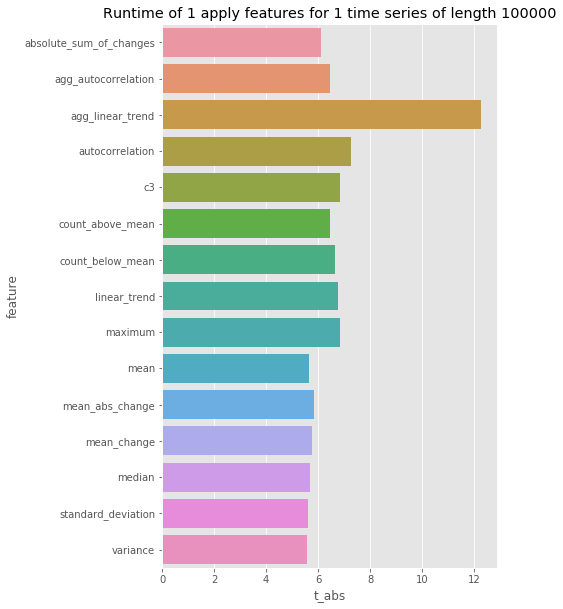

In [11]:
show_ts_performance(settings)

In [41]:
import joblib 

evals_result = {} 

@telegram_sender(token=TELEGRAM_API_KEY, chat_id=CHAT_ID)
def model_train(params):
    seed = 42
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)

    lgbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=(lgb_train),
                early_stopping_rounds=100,
                evals_result = evals_result,
                verbose_eval = 10)
    return lgbm

In [9]:
import gc
gc.collect()
gc.collect()

0

In [17]:
52 / 2

26.0

In [18]:
52 / 3

17.333333333333332

In [19]:
52 / 4

13.0

In [20]:
52 / 6

8.666666666666666

In [10]:
train_df = pd.read_pickle(root + "train_features.pkl")
full_train_df = train_df.drop('timestamp', axis=1)
full_train_df = full_train_df.query('[1, 2] in site_id')
full_train_df = full_train_df.reset_index(drop=True)
target = full_train_df['meter_reading_log1p']
full_train_df['dew_temperature'] = full_train_df['dew_temperature'].fillna(-999)

<function __main__.generate_ts_features(X_train, y_col_name, time_col, settings)>

In [90]:
def generate_and_merge(X_train, setting_1, setting_2):
    features_2 = generate_ts_features(X_train, 'meter_reading_log1p', 'weekofyear_datetime', setting_2)
    features_3 = generate_ts_features(X_train, 'dew_temperature',     'weekofyear_datetime', setting_2)
    
    features = pd.concat((features_2, features_3), axis=1)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    print(X_train.shape)
    
    kfold = KFold(2)
    features_part = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kfold.split(X_train)):
        train_part = X_train.loc[test_index]
        features_1 = generate_ts_features(train_part, 'dew_temperature', 'weekofyear_datetime', setting_2).add_suffix("_" + str(i))
        features_2 = generate_ts_features(train_part, 'meter_reading_log1p', 'weekofyear_datetime', setting_2).add_suffix("_" + str(i))    
        
            
        features_3 = generate_ts_features(X_train, 'meter_reading_log1p', 'hour_datetime', setting_1)
        features_4 = generate_ts_features(X_train, 'dew_temperature',     'hour_datetime', setting_1)
        
        f = pd.concat((features_1, features_2, features_3, features_4), axis=1)        
        features_part = pd.concat((features_part, f), axis=1)
        print(features_part.shape)
        
    X_train = X_train.merge(features_part, how='left', left_on=KEY_NAME, right_on='id')
    print(X_train.shape)    
    return X_train,features


In [101]:
def generate_and_merge(X_train, X_test, settings_week, settings_hour, kfold_settings):
    features_1 = generate_ts_features(X_train, 'meter_reading_log1p', 'dayofyear_datetime', settings_week)
    features_2 = generate_ts_features(X_train, 'meter_reading_log1p', 'hour_datetime', settings_hour)
     
    X_train = X_train.merge(pd.concat((features_1, features_2), axis=1), how='left', left_on=KEY_NAME, right_on='id')
    kfold = KFold(2)
    features_part = pd.DataFrame()
    for i, (train_index, test_index) in enumerate(kfold.split(X_train)):
        train_part = X_train.loc[test_index]
        features_1 = generate_ts_features(
            train_part, 'dew_temperature', 'dayofyear_datetime', kfold_settings, 'building_id').add_suffix("_" + str(i))   
        features_2 = generate_ts_features(
            train_part, 'sea_level_pressure', 'dayofyear_datetime', kfold_settings, 'building_id').add_suffix("_" + str(i))    
       
        features_3 = generate_ts_features(
            train_part, 'sea_level_pressure', 'dayofyear_datetime', kfold_settings, 'building_id').add_suffix("_" + str(i))    

        f = pd.concat((features_1, features_2, features_3), axis=1)        
        features_part = pd.concat((features_part, f), axis=1)
        print(features_part.shape)
  
    X_train = X_train.merge(features_part, how='left', left_on='building_id', right_on='id')

    features_1 = generate_ts_features(X_train, 'sea_level_pressure', 'weekofyear_datetime', kfold_settings)
    features_2 = generate_ts_features(X_train, 'dew_temperature',     'weekofyear_datetime', kfold_settings)
    features_3 = generate_ts_features(X_train, 'air_temperature',     'weekofyear_datetime', kfold_settings)

    features = pd.concat((features_1, features_2, features_3), axis=1)
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if np.any(X_test):    
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test, features

In [105]:
settings_1 =  load_settings('hour_datetime_ts_settings.json')
settings_2 =  load_settings('weekofyear_ts_settings.json')

train_X = full_train_df[[*feat_cols, 'meter_reading_log1p']].reset_index(drop=True)
train_X = train_X.fillna(0)
train_y = target

In [106]:
## Feature generation
train_X, test_X, tsfresh_features = generate_and_merge(train_X, None, settings_1, settings_2, MinimalFCParameters())
##
train_X.drop('meter_reading_log1p', axis=1, inplace=True)

Mem. usage decreased to  0.02 Mb (72.1% reduction)
Time 3.820136308670044
Mem. usage decreased to  0.02 Mb (72.1% reduction)
Time 3.85141658782959


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 2.9342782497406006


 'sea_level_pressure__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 2.869509696960449


 'sea_level_pressure__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 2.881779432296753
(186, 24)


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 2.8585236072540283


 'sea_level_pressure__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 2.977250576019287


 'sea_level_pressure__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.00 Mb (66.7% reduction)
Time 3.024441719055176
(186, 48)


 'sea_level_pressure__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.01 Mb (66.7% reduction)
Time 6.59572434425354


Mem. usage decreased to  0.01 Mb (66.7% reduction)
Time 6.297693729400635


 'air_temperature__variance'] did not have any finite values. Filling with zeros.


Mem. usage decreased to  0.01 Mb (66.7% reduction)
Time 6.180493116378784


In [111]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3083669 entries, 0 to 3083668
Columns: 145 entries, building_id to air_temperature__variance
dtypes: float16(128), int16(6), int32(2), int8(9)
memory usage: 861.7 MB


In [107]:
lgbm = model_train({ 'metric': {'rmse'}})

Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 1.07244
[20]	training's rmse: 0.873372
[30]	training's rmse: 0.798327
[40]	training's rmse: 0.747824
[50]	training's rmse: 0.709532
[60]	training's rmse: 0.679689
[70]	training's rmse: 0.65881
[80]	training's rmse: 0.640167
[90]	training's rmse: 0.622993
[100]	training's rmse: 0.611922
[110]	training's rmse: 0.599619
[120]	training's rmse: 0.58958
[130]	training's rmse: 0.579552
[140]	training's rmse: 0.571499
[150]	training's rmse: 0.563648
[160]	training's rmse: 0.55636
[170]	training's rmse: 0.548702
[180]	training's rmse: 0.542594
[190]	training's rmse: 0.536746
[200]	training's rmse: 0.531953
[210]	training's rmse: 0.527585
[220]	training's rmse: 0.523493
[230]	training's rmse: 0.519558
[240]	training's rmse: 0.516085
[250]	training's rmse: 0.512332
[260]	training's rmse: 0.509063
[270]	training's rmse: 0.50519
[280]	training's rmse: 0.501529
[290]	training's rmse: 0.498246
[300]	training's rmse: 0

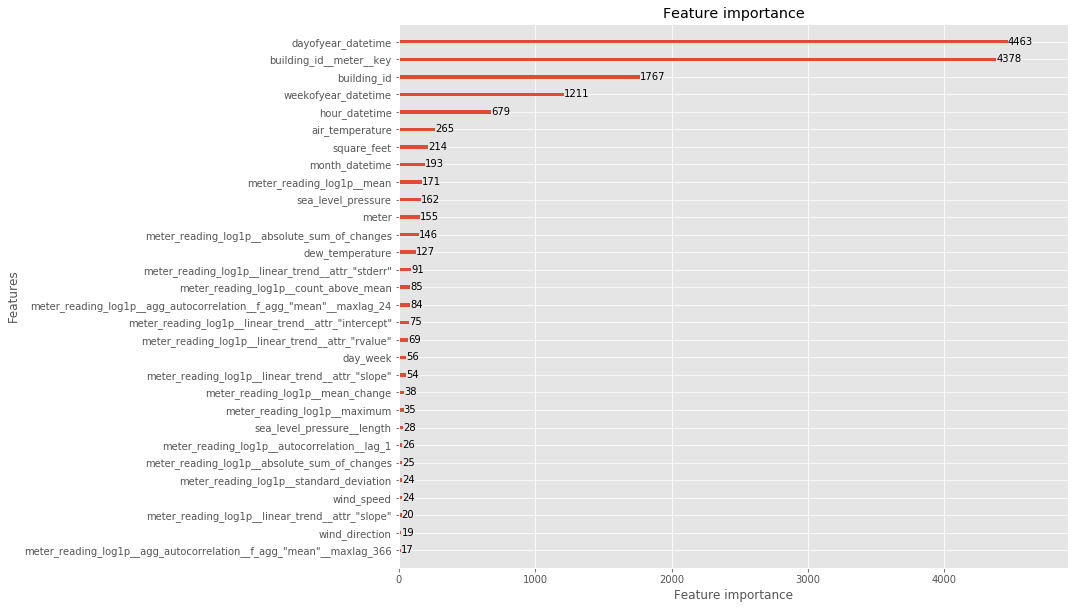

In [108]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(lgbm, max_num_features=30, ax=ax)
plt.show()

In [50]:

import operator

l = list(zip(train_X.columns, lgbm.feature_importance()))
l.sort(key=operator.itemgetter(1), reverse=True)
l

[('dayofyear_datetime', 4470),
 ('building_id__meter__key', 4186),
 ('building_id', 1558),
 ('weekofyear_datetime', 1241),
 ('hour_datetime', 708),
 ('air_temperature', 292),
 ('square_feet', 273),
 ('month_datetime', 204),
 ('sea_level_pressure', 201),
 ('dew_temperature', 169),
 ('meter_reading_log1p__mean_weekofyear_datetime', 152),
 ('meter_reading_log1p__absolute_sum_of_changes_weekofyear_datetime', 146),
 ('meter', 135),
 ('meter_reading_log1p__linear_trend__attr_"stderr"_weekofyear_datetime', 84),
 ('meter_reading_log1p__agg_autocorrelation__f_agg_"mean"__maxlag_52_weekofyear_datetime',
  80),
 ('meter_reading_log1p__count_above_mean_weekofyear_datetime', 77),
 ('day_week', 62),
 ('meter_reading_log1p__linear_trend__attr_"rvalue"_weekofyear_datetime', 53),
 ('meter_reading_log1p__linear_trend__attr_"intercept"_weekofyear_datetime',
  51),
 ('meter_reading_log1p__agg_autocorrelation__f_agg_"var"__maxlag_52_weekofyear_datetime',
  48),
 ('meter_reading_log1p__linear_trend__attr_"s


Estimated running time:  21896.561617452302
Estimated running time:  364.94269362420505
Estimated running time:  6.082378227070084


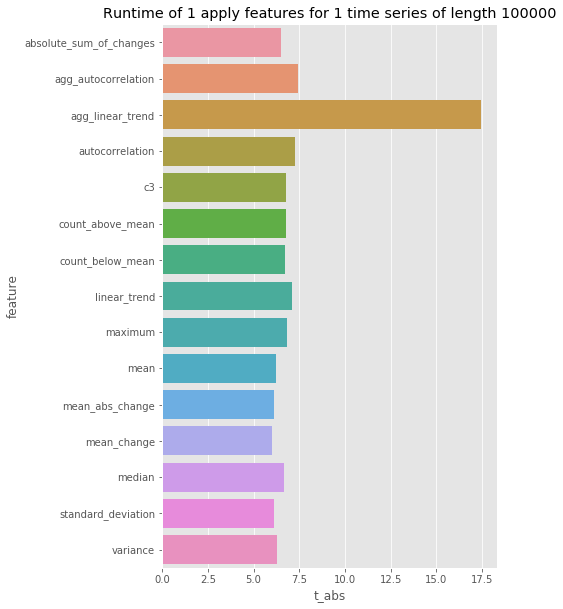

In [38]:
show_ts_performance(settings)

In [100]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'age', 'month_datetime', 'weekofyear_datetime',
       'dayofyear_datetime', 'hour_datetime', 'day_week', 'day_month_datetime',
       'week_month_datetime', 'building_id__meter__key',
       'meter_reading_log1p'],
      dtype='object')

NameError: name 'lgbm' is not defined

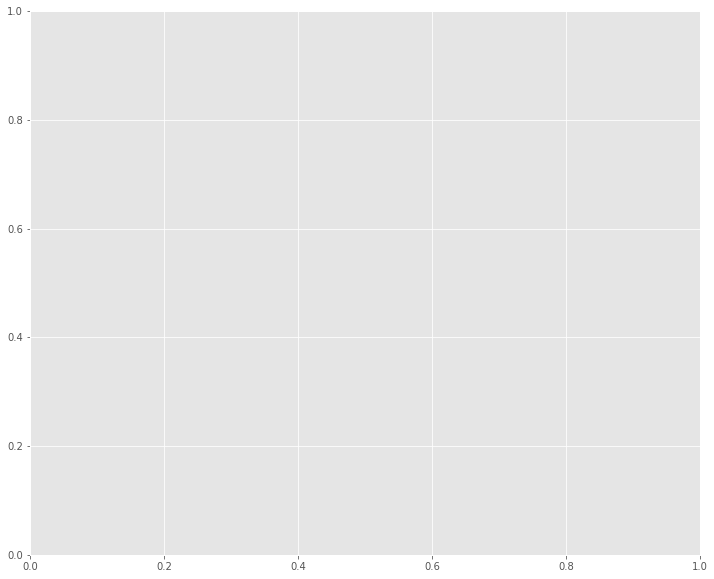

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(lgbm, max_num_features=20, ax=ax)
plt.show()